In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.utils import resample
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout,Flatten,MaxPooling1D,LSTM,Bidirectional,BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
dataset_path = []

for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename.endswith('.csv'):
            dfp = os.path.join(dirname, filename)
            dataset_path.append(dfp)

dataset\DNS-testing.csv
dataset\Syn-testing.csv
dataset\UDP-training.csv


In [8]:
cols = list(pd.read_csv(dataset_path[1], nrows=1))

def load_file(path):
    # data = pd.read_csv(path, sep=',')
    data = pd.read_csv(path,
                   usecols =[i for i in cols if i != " Source IP"
                             and i != ' Destination IP' and i != 'Flow ID'
                             and i != 'SimillarHTTP' and i != 'Unnamed: 0'])

    return data

In [9]:
samples = pd.concat([load_file(dfp) for dfp in dataset_path], ignore_index=True)

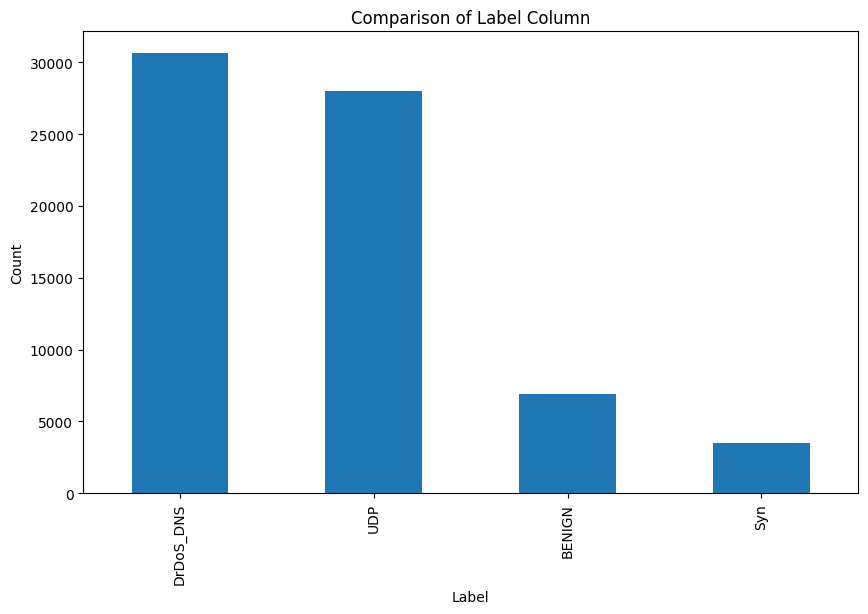

In [10]:

label_counts = samples[' Label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Comparison of Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:

def string2numeric_hash(text):
    import hashlib
    return int(hashlib.md5(text).hexdigest()[:8], 16)

samples = samples.replace('Infinity','0')
samples = samples.replace(np.inf,0)
samples[' Flow Packets/s'] = pd.to_numeric(samples[' Flow Packets/s'])

samples['Flow Bytes/s'] = samples['Flow Bytes/s'].fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'])


label_encoder = LabelEncoder()

samples[' Label'] = label_encoder.fit_transform(samples[' Label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for label, encoded_value in label_mapping.items():
    print(f"Label: {label} - Encoded Value: {encoded_value}")

colunaTime = pd.DataFrame(samples[' Timestamp'].str.split(' ', n=1, expand=True), columns=['dia', 'horas'])
colunaTime['horas'] = colunaTime['horas'].astype(str)
colunaTime = pd.DataFrame(colunaTime['horas'].str.split('.', n=1, expand=True),columns = ['horas','milisec'])
colunaTime['horas'] = colunaTime['horas'].astype(str)
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
samples[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))#colunaTime['horas']
del colunaTime,stringHoras


print('Training data processed')

Label: BENIGN - Encoded Value: 0
Label: DrDoS_DNS - Encoded Value: 1
Label: Syn - Encoded Value: 2
Label: UDP - Encoded Value: 3
Training data processed


In [12]:
samples

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,910,20073,17,2748505718,48,2,0,2944.0,0.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,588,39159,17,2748505718,2,2,0,2944.0,0.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,953,22161,17,2748505718,1,2,0,2944.0,0.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,663,18811,17,2748505718,1,2,0,2944.0,0.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,591,4168,17,2748505718,1,2,0,2896.0,0.0,1448.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69093,43570,46295,17,2748505718,108769,4,0,1398.0,0.0,369.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
69094,59169,17787,17,2748505718,107895,4,0,1438.0,0.0,389.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
69095,42296,47362,17,2748505718,1,2,0,750.0,0.0,375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
69096,59452,5824,17,2748505718,108870,4,0,1398.0,0.0,369.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3


In [18]:
def train_test(samples, variance_ratio=0.95):
    from sklearn.model_selection import train_test_split
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    X = samples.iloc[:, 0:(samples.shape[1] - 1)]
    y = samples.iloc[:, -1]

    plt.figure(figsize=(10, 7))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='viridis')
    plt.xlabel(f'Feature 1: {X.columns[0]}')
    plt.ylabel(f'Feature 2: {X.columns[1]}')
    plt.title('Scatter Plot Before PCA')
    plt.colorbar(label='Target')
    plt.show()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=variance_ratio)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 7))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Scatter Plot')
    plt.colorbar(label='Target')
    plt.show()

    print(f'Number of components selected: {pca.n_components_}')
    components_df = pd.DataFrame(pca.components_, columns=X.columns)
    for i, component in enumerate(components_df.values):
        print(f"\nPrincipal Component {i + 1}:")
        top_contributing_features = np.abs(component).argsort()[::-1]
        for feature_idx in top_contributing_features:
            print(f"Feature: {X.columns[feature_idx]}")
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33, random_state=42)

    return X_train, X_test, y_train, y_test


In [14]:
def format_3d(df):

    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

In [15]:

def compile_train(model,X_train,y_train,deep=True, epochs=10):

    if(deep==True):
        import matplotlib.pyplot as plt
#         optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=0.001)
#         model_lstm2.compile(optimizer=optimizer)

#         model.compile(loss='binary_crossentropy',
#                       optimizer='adam',
#                       metrics=['accuracy'])
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        history = model.fit(X_train, y_train,epochs=epochs, batch_size=32, verbose=1)
        #model.fit(X_train, y_train,epochs=3)

        plt.plot(history.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()

        print(model.metrics_names)

    else:
        model.fit(X_train, y_train)

    print('Model Compiled and Trained')
    return model

In [16]:
def save_model(model,name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)

    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')

def load_model(name):
    from keras.models import model_from_json

    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)

    print('Model loaded')

    return loaded_model

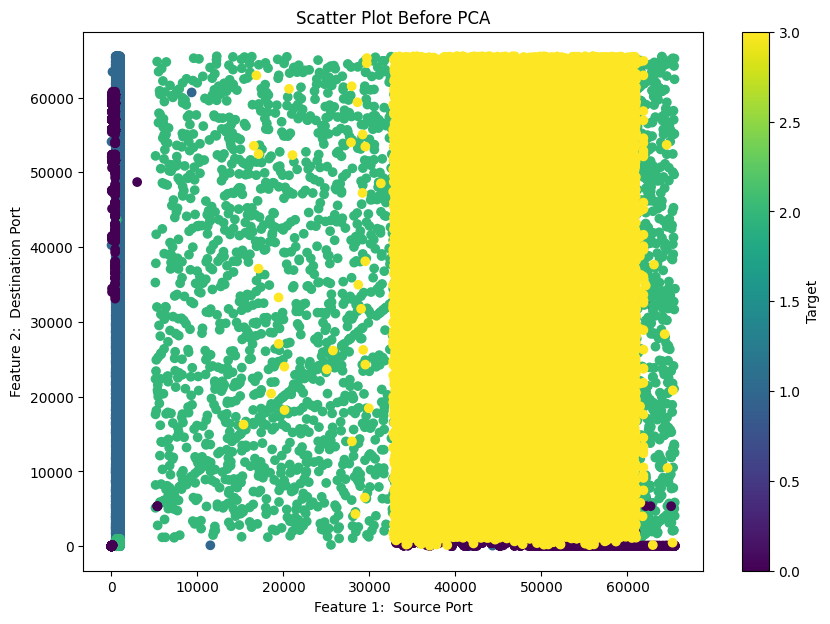

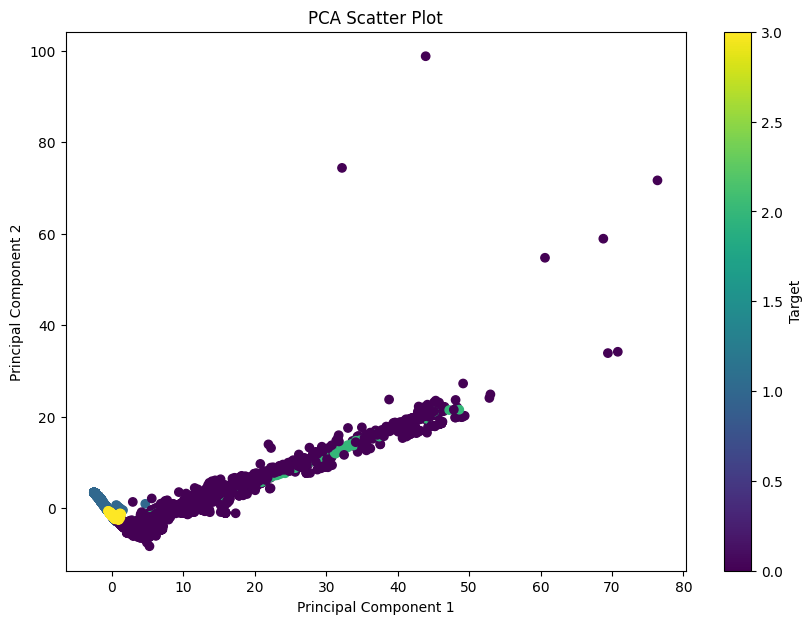

Number of components selected: 25

Principal Component 1:
Feature:  Flow IAT Max
Feature:  Fwd IAT Max
Feature:  Idle Max
Feature: Idle Mean
Feature:  Fwd IAT Std
Feature:  Flow Duration
Feature:  Flow IAT Std
Feature: Fwd IAT Total
Feature:  Idle Min
Feature:  Fwd IAT Mean
Feature:  Bwd IAT Max
Feature: Bwd IAT Total
Feature:  Bwd IAT Std
Feature:  Flow IAT Mean
Feature:  Bwd IAT Mean
Feature:  Min Packet Length
Feature:  Fwd Packet Length Min
Feature:  Avg Fwd Segment Size
Feature:  Fwd Packet Length Mean
Feature:  Packet Length Std
Feature:  Protocol
Feature:  Average Packet Size
Feature:  Packet Length Mean
Feature:  Inbound
Feature:  Bwd Packet Length Std
Feature: Bwd Packet Length Max
Feature: Init_Win_bytes_forward
Feature:  Avg Bwd Segment Size
Feature:  Bwd Packet Length Mean
Feature: Flow Bytes/s
Feature:  Source Port
Feature:  Fwd Packet Length Max
Feature:  ACK Flag Count
Feature:  Fwd Packet Length Std
Feature:  Idle Std
Feature:  Packet Length Variance
Feature: Fwd Packet

In [19]:

X_train, X_test, y_train, y_test = train_test(samples)

y_train_df = pd.DataFrame(y_train)

X = pd.DataFrame(X_train)

from imblearn.over_sampling import SMOTE

print("Class distribution before SMOTE:")
print(y_train_df.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y_train_df)

y_train_resampled = pd.DataFrame(y_train_resampled)

print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

input_size = (X_train_resampled.shape[1], 1)

del X


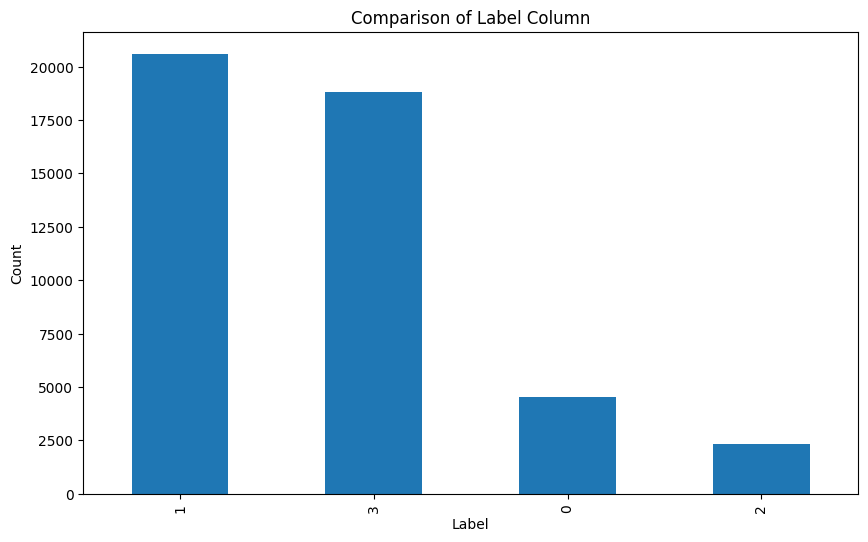

In [12]:

label_counts = y_train.value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Comparison of Label Column')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:

# labels = to_categorical(samples[' Label'])
y_train= to_categorical(y_train)
y_test= to_categorical(y_test)

In [14]:
def CNN_LSTM_model(input_size):
    model = Sequential()
    input_tensor = layers.Input(shape=(input_size[0], input_size[1]), batch_size=32)

    # Batch Normalization
    x = layers.BatchNormalization()(input_tensor)
    conv1 = layers.Conv1D(8, 3, padding='same', activation='relu')(x)
    conv1c = layers.Conv1D(16, 3, padding='same', activation='relu')(conv1)
    flow1 = layers.MaxPooling1D(pool_size=2)(conv1c)
    
    # Final Convolutional and Pooling Layers
    conv_final = layers.Conv1D(8, 1, padding='same', activation='relu')(flow1)
    
    # Average Pooling before LSTM
    pooled = layers.AveragePooling1D(pool_size=2)(conv_final)
    lstm_output = layers.LSTM(25, return_sequences=False, activation='relu')(pooled)
    
    # Flatten and Fully Connected Layers
    flatten = layers.Flatten()(lstm_output)
    dense = layers.Dense(4, activation='softmax')(flatten)  # 4 nodes for output classification
    
    # Model
    model = Model(inputs=input_tensor, outputs=dense)
    print(model.summary())

    return model


In [16]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test(samples, variance_ratio=0.95)

# One-hot encode the y_train labels
y_train = to_categorical(y_train)

input_size = (X_train.shape[1], 1)
print("This is input:",input_size)
model_lstm2 = CNN_LSTM_model(input_size)

# model_lstm2 = compile_train(model_lstm2, format_3d(X_train.astype(np.float32)), y_train.astype(np.float32), epochs=50)


Number of components selected: 25

Principal Component 1:
Feature:  Flow IAT Max
Feature:  Fwd IAT Max
Feature:  Idle Max
Feature: Idle Mean
Feature:  Fwd IAT Std
Feature:  Flow Duration
Feature:  Flow IAT Std
Feature: Fwd IAT Total
Feature:  Idle Min
Feature:  Fwd IAT Mean
Feature:  Bwd IAT Max
Feature: Bwd IAT Total
Feature:  Bwd IAT Std
Feature:  Flow IAT Mean
Feature:  Bwd IAT Mean
Feature:  Min Packet Length
Feature:  Fwd Packet Length Min
Feature:  Avg Fwd Segment Size
Feature:  Fwd Packet Length Mean
Feature:  Packet Length Std
Feature:  Protocol
Feature:  Average Packet Size
Feature:  Packet Length Mean
Feature:  Inbound
Feature:  Bwd Packet Length Std
Feature: Bwd Packet Length Max
Feature: Init_Win_bytes_forward
Feature:  Avg Bwd Segment Size
Feature:  Bwd Packet Length Mean
Feature: Flow Bytes/s
Feature:  Source Port
Feature:  Fwd Packet Length Max
Feature:  ACK Flag Count
Feature:  Fwd Packet Length Std
Feature:  Idle Std
Feature:  Packet Length Variance
Feature: Fwd Packet

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (32, 25, 1)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 25, 1)            │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (32, 25, 8)            │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (32, 25, 16)           │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (32, 12, 16)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (32, 12, 8)            │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (32, 6, 8)             │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 25)               │         3,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 25)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,076 (15.92 KB)

 Trainable params: 4,074 (15.91 KB)

 Non-trainable params: 2 (8.00 B)

None


In [ ]:
!mkdir Models

In [ ]:
!touch 'Models/lstm_50e.json'
save_model(model_lstm2,"lstm_50e")

In [ ]:
del model_lstm2

In [ ]:
!cp -r /kaggle/input/lstm-ddos-model/* /kaggle/working/Models/

In [ ]:
!ls -lah Models

In [ ]:
# model_lstm = load_model('lstm_50e')
# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
y_pred = model_lstm2.predict(format_3d(X_test))

y_pred = y_pred.round()

713/713 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [17]:
y_pred_label = np.argmax(y_pred, axis=1)
# y_test_label = np.argmax(y_test, axis=1)
y_test_label=y_test

In [18]:
# score = model_lstm2.evaluate(X_test, y_test,verbose=1)

# print(score)

accuracy_score(y_test_label, y_pred_label)

0.999254484059115

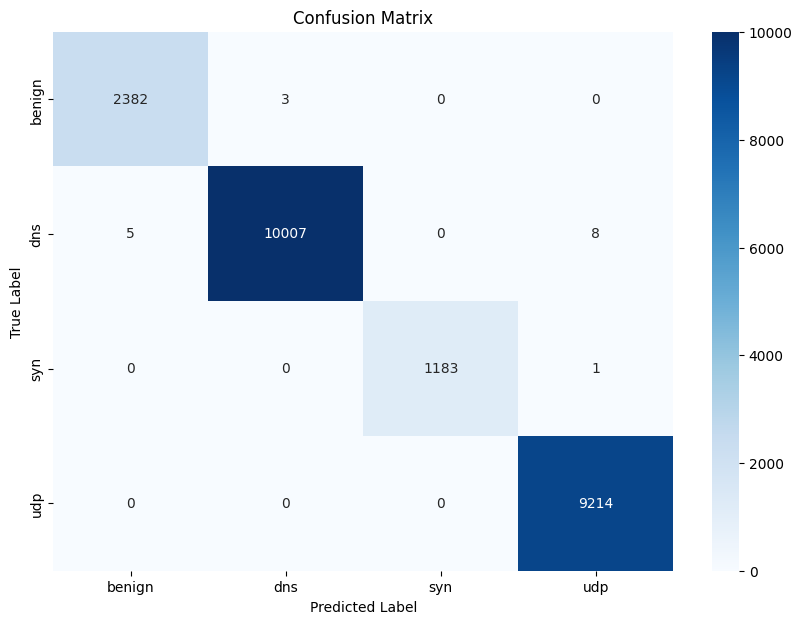

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
labels = ['benign', 'dns', 'syn', 'udp']
cm = confusion_matrix(y_test_label, y_pred_label,)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=np.arange(cm.shape[1]),
#             yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:

classification_report(y_test_label, y_pred_label)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      2385\n           1       1.00      1.00      1.00     10020\n           2       1.00      1.00      1.00      1184\n           3       1.00      1.00      1.00      9214\n\n    accuracy                           1.00     22803\n   macro avg       1.00      1.00      1.00     22803\nweighted avg       1.00      1.00      1.00     22803\n'